# 05 — Customer Segmentation (Unsupervised ML)

- E-commerce Customer Segmentation & Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
import joblib

from sklearn.neighbors import NearestNeighbors

In [2]:
warnings.filterwarnings("ignore")

In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 100

### Loading and preparing the RFM Data

In [4]:


# Load RFM data
rfm = pd.read_csv("../data/rfm_data.csv", dtype={"CustomerID": str})

# Load train and test scaled separately
X_train_scaled = pd.read_csv("../data/rfm_train_scaled.csv", index_col=0)
X_test_scaled  = pd.read_csv("../data/rfm_test_scaled.csv", index_col=0)

print(f"RFM Shape          : {rfm.shape}")
print(f"Train Scaled Shape : {X_train_scaled.shape}")
print(f"Test Scaled Shape  : {X_test_scaled.shape}")
print("\n\nData loaded successfully")

RFM Shape          : (4338, 7)
Train Scaled Shape : (3470, 3)
Test Scaled Shape  : (868, 3)


Data loaded successfully


In [18]:
# Combine train and test scaled for visualization and comparison algorithms

rfm_scaled = pd.concat([X_train_scaled, X_test_scaled]).sort_index()
print(f"Full Scaled Shape: {rfm_scaled.shape}")
print("Combined scaled data ready")

Full Scaled Shape: (4338, 3)
Combined scaled data ready


### Elbow Method (Finding Optimal K)

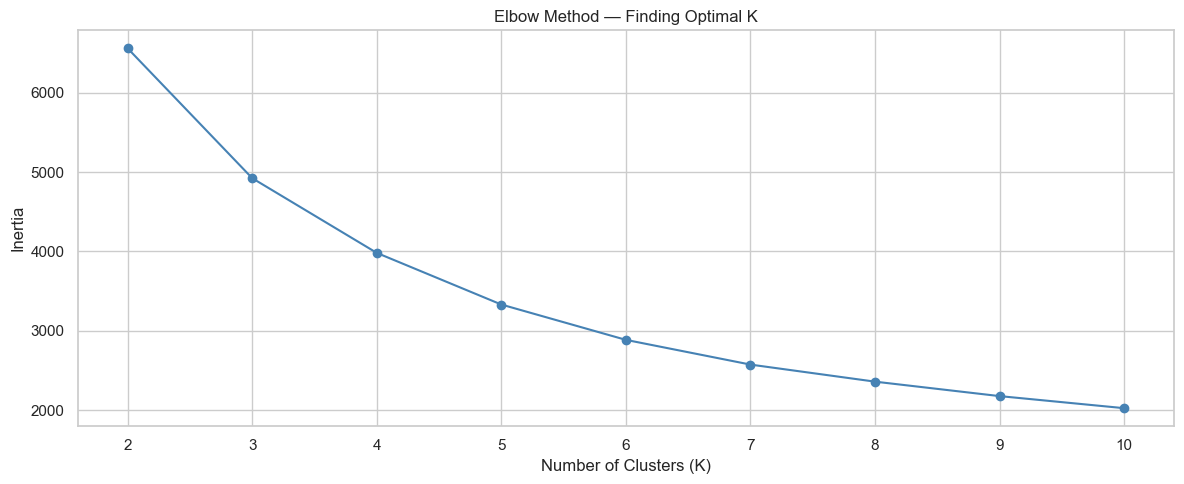

In [26]:
inertia = []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=10)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(12, 5))
plt.plot(k_range, inertia, marker="o", color="steelblue")
plt.title("Elbow Method — Finding Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.xticks(k_range)
plt.tight_layout()
plt.show()

### Silhouette Score

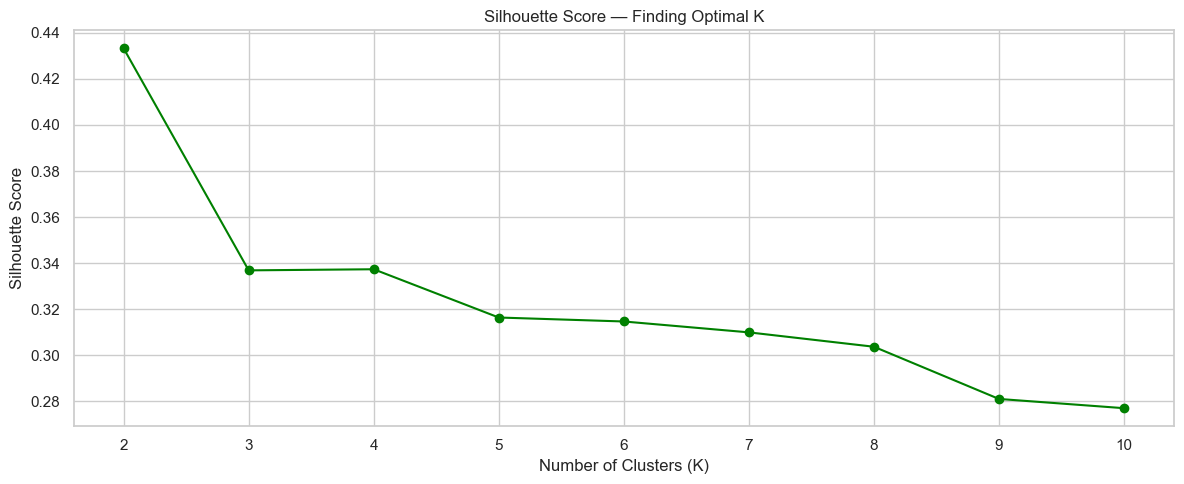

Highest Silhouette Score at K : 2
Note: We use K=4 based on Elbow Method and business context


In [27]:
silhouette_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=10)
    labels = km.fit_predict(rfm_scaled)
    silhouette_scores.append(silhouette_score(rfm_scaled, labels))

plt.figure(figsize=(12, 5))
plt.plot(k_range, silhouette_scores, marker="o", color="green")
plt.title("Silhouette Score — Finding Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.xticks(k_range)
plt.tight_layout()
plt.show()

# Just print it — don't assign best_k here
print(f"Highest Silhouette Score at K : {k_range[silhouette_scores.index(max(silhouette_scores))]}")
print("Note: We use K=4 based on Elbow Method and business context")

### KMeans

In [7]:
# KMeans fitted on TRAINING data only

kmeans = KMeans(n_clusters=4, init="k-means++", random_state=42, n_init=10)
kmeans.fit(X_train_scaled)

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",4
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",10
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",42
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


In [8]:
# Predict on full dataset for segment assignment

rfm_full_scaled = pd.concat([X_train_scaled, X_test_scaled])
rfm_full_scaled = rfm_full_scaled.sort_index()

In [9]:
# segment maping

rfm["KMeans_Cluster"] = kmeans.predict(rfm_full_scaled)

segment_map = {
    0: "At-Risk Customers",
    1: "Lost Customers",
    2: "Champions",
    3: "Loyal Customers"
}

rfm["KMeans_Segment"] = rfm["KMeans_Cluster"].map(segment_map)

print(f"KMeans Clusters : 4")
print(f"\nCluster Distribution:")
print(rfm["KMeans_Cluster"].value_counts().sort_index())

KMeans Clusters : 4

Cluster Distribution:
KMeans_Cluster
0     833
1    1617
2    1167
3     721
Name: count, dtype: int64


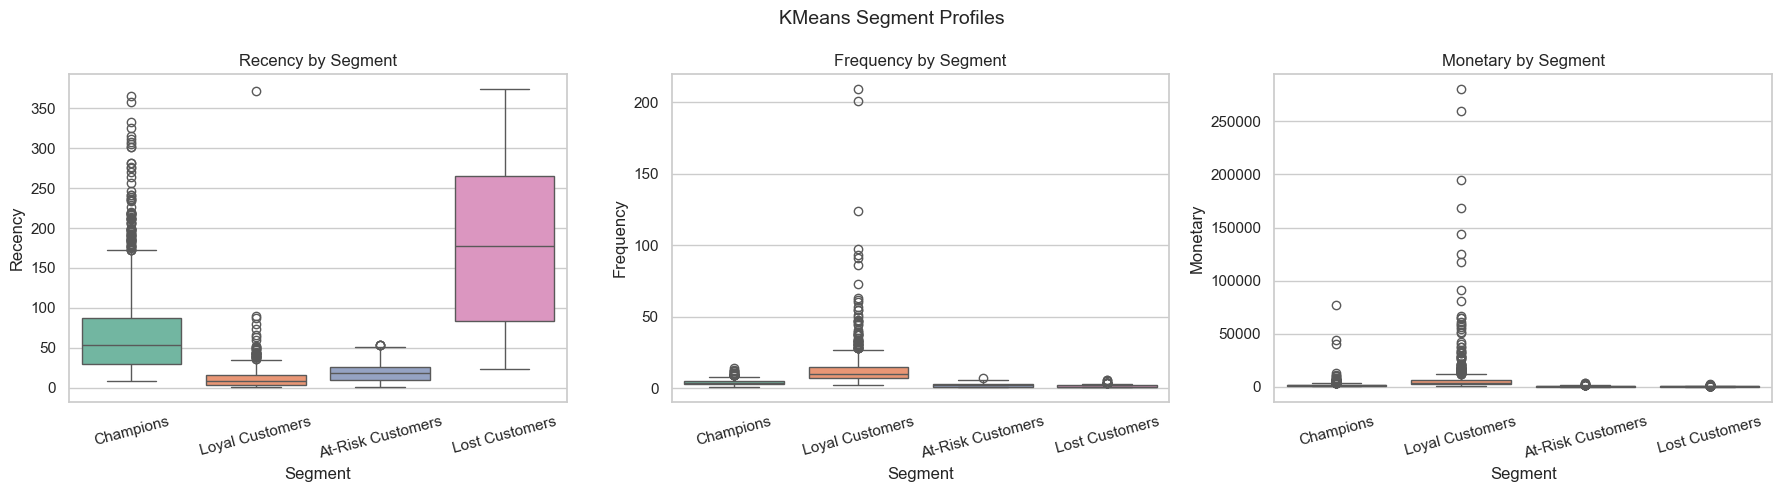

In [10]:
# KMeans Segment Visualization

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(["Recency", "Frequency", "Monetary"]):
    sns.boxplot(
        data=rfm,
        x="KMeans_Segment",
        y=col,
        palette="Set2",
        ax=axes[i]
    )
    axes[i].set_title(f"{col} by Segment")
    axes[i].set_xlabel("Segment")
    axes[i].tick_params(axis="x", rotation=15)

plt.suptitle("KMeans Segment Profiles", fontsize=14)
plt.tight_layout()
plt.show()

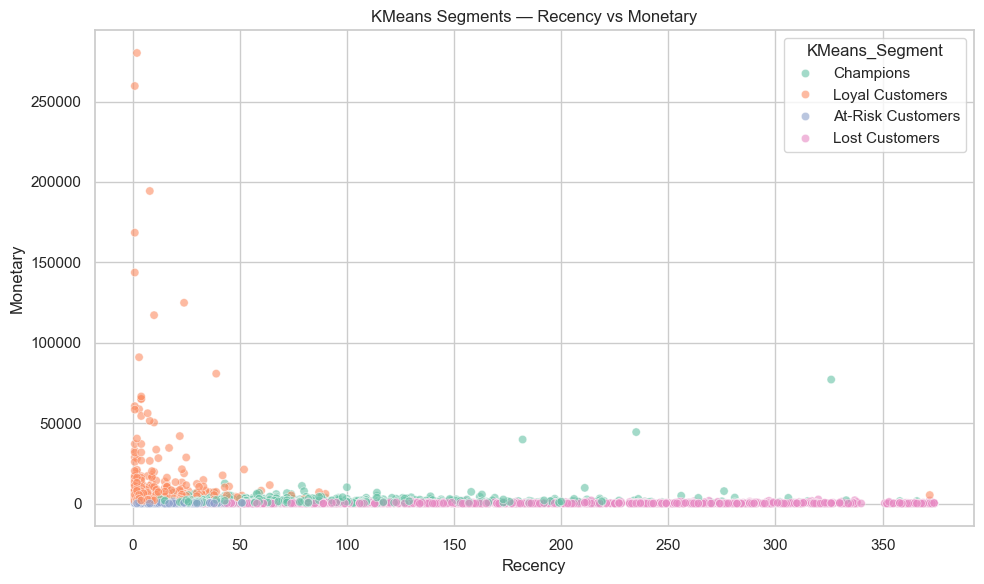

In [11]:
# K-Means Scatter Plot

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfm,
    x="Recency",
    y="Monetary",
    hue="KMeans_Segment",
    palette="Set2",
    alpha=0.6
)
plt.title("KMeans Segments — Recency vs Monetary")
plt.tight_layout()
plt.show()

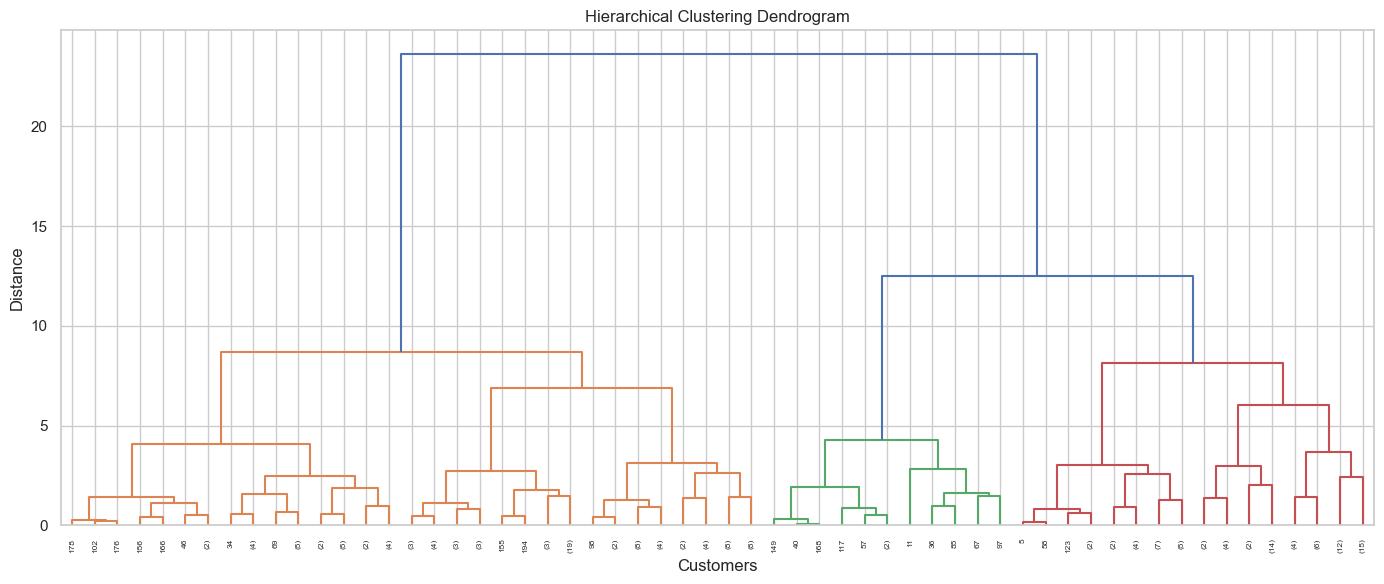

In [19]:
# Hierarchical Clustering Dendrogram

sample = rfm_scaled.sample(200, random_state=42)
linked = linkage(sample, method="ward")

plt.figure(figsize=(14, 6))
dendrogram(linked, truncate_mode="level", p=5, color_threshold=10)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Customers")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

### Hierarchical Clustering

In [20]:
# Hierarchical Clustering

hierarchical = AgglomerativeClustering(n_clusters=4, linkage="ward")
rfm["Hierarchical_Cluster"] = hierarchical.fit_predict(rfm_scaled)

print("Hierarchical Cluster Distribution:")
print(rfm["Hierarchical_Cluster"].value_counts().sort_index())

Hierarchical Cluster Distribution:
Hierarchical_Cluster
0    1525
1    1227
2     898
3     688
Name: count, dtype: int64


In [21]:
# Hierarchical Clustering profile

hierarchical_profile = rfm.groupby("Hierarchical_Cluster").agg(
    Recency_Mean   = ("Recency", "mean"),
    Frequency_Mean = ("Frequency", "mean"),
    Monetary_Mean  = ("Monetary", "mean"),
    Customer_Count = ("CustomerID", "count")
).round(2)

print("Hierarchical Cluster Profiles:")
hierarchical_profile

Hierarchical Cluster Profiles:


,Recency_Mean,Frequency_Mean,Monetary_Mean,Customer_Count
Hierarchical_Cluster,,,,
0,87.75,3.79,1817.62,1525
1,35.89,1.78,465.23,1227
2,240.97,1.18,249.65,898
3,10.44,13.80,7733.02,688


### DBSCAN K-Distance Graph

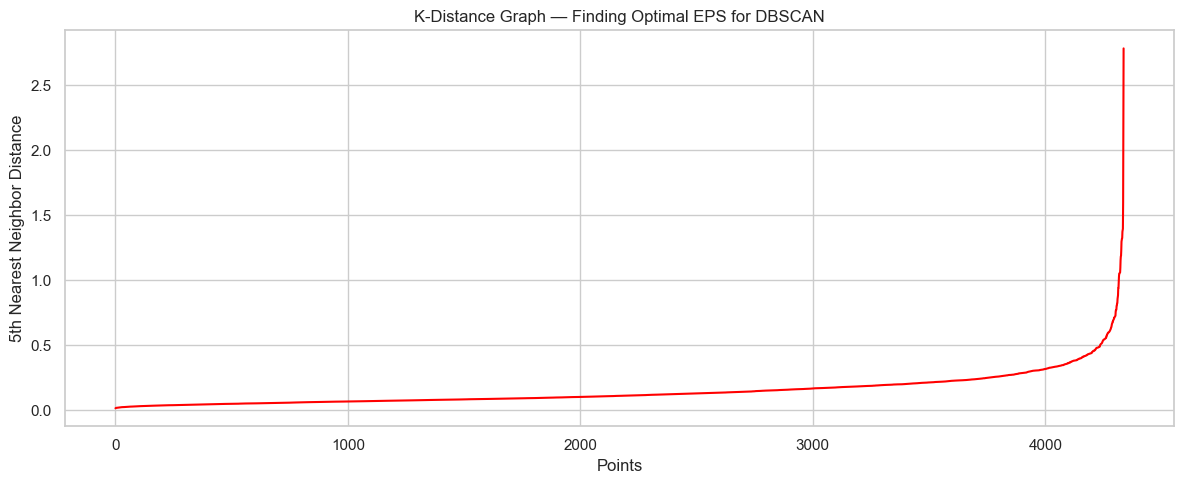

In [22]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors.fit(rfm_scaled)
distances, _ = neighbors.kneighbors(rfm_scaled)
distances = np.sort(distances[:, 4])

plt.figure(figsize=(12, 5))
plt.plot(distances, color="red")
plt.title("K-Distance Graph — Finding Optimal EPS for DBSCAN")
plt.xlabel("Points")
plt.ylabel("5th Nearest Neighbor Distance")
plt.tight_layout()
plt.show()

In [23]:
# DBSCAN Clusterring

dbscan = DBSCAN(eps=0.5, min_samples=5)
rfm["DBSCAN_Cluster"] = dbscan.fit_predict(rfm_scaled)

n_clusters = len(set(rfm["DBSCAN_Cluster"])) - (1 if -1 in rfm["DBSCAN_Cluster"].values else 0)
noise = (rfm["DBSCAN_Cluster"] == -1).sum()

print(f"DBSCAN Clusters Found : {n_clusters}")
print(f"Noise Points          : {noise:,}")
print(f"\nCluster Distribution:")
print(rfm["DBSCAN_Cluster"].value_counts().sort_index())

DBSCAN Clusters Found : 2
Noise Points          : 62

Cluster Distribution:
DBSCAN_Cluster
-1      62
 0    2791
 1    1485
Name: count, dtype: int64


In [24]:
# Algorithm Comparison 

kmeans_sil       = silhouette_score(rfm_scaled, rfm["KMeans_Cluster"])
hierarchical_sil = silhouette_score(rfm_scaled, rfm["Hierarchical_Cluster"])

dbscan_labels = rfm["DBSCAN_Cluster"]
valid_dbscan  = dbscan_labels[dbscan_labels != -1]
if len(set(valid_dbscan)) > 1:
    dbscan_sil = silhouette_score(
        rfm_scaled[dbscan_labels != -1],
        valid_dbscan
    )
else:
    dbscan_sil = "N/A — insufficient clusters"


print("ALGORITHM COMPARISON\n\n")

print(f"KMeans Silhouette Score       : {kmeans_sil:.4f}")
print(f"Hierarchical Silhouette Score : {hierarchical_sil:.4f}")
print(f"DBSCAN Silhouette Score       : {dbscan_sil}")


ALGORITHM COMPARISON


KMeans Silhouette Score       : 0.3362
Hierarchical Silhouette Score : 0.2790
DBSCAN Silhouette Score       : 0.293520345236721


### Business Recommendations

In [25]:

print("BUSINESS RECOMMENDATIONS PER SEGMENT\n\n")

print("""
🏆 Champions (716 customers)
   → Reward with loyalty programs and early access
   → Ask for reviews and referrals
   → Offer premium memberships

💛 Loyal Customers (1,175 customers)
   → Upsell higher value products
   → Send personalized recommendations
   → Offer membership upgrades

⚠️  At-Risk Customers (831 customers)
   → Send win-back email campaigns
   → Offer limited time discounts
   → Ask for feedback on why engagement dropped

💤 Lost Customers (1,616 customers)
   → Aggressive re-engagement offers
   → Survey to understand churn reasons
   → Consider deprioritizing marketing spend
""")

print("\n\nSegmentation complete — proceed to 06_prediction.ipynb")

BUSINESS RECOMMENDATIONS PER SEGMENT



🏆 Champions (716 customers)
   → Reward with loyalty programs and early access
   → Ask for reviews and referrals
   → Offer premium memberships

💛 Loyal Customers (1,175 customers)
   → Upsell higher value products
   → Send personalized recommendations
   → Offer membership upgrades

⚠️  At-Risk Customers (831 customers)
   → Send win-back email campaigns
   → Offer limited time discounts
   → Ask for feedback on why engagement dropped

💤 Lost Customers (1,616 customers)
   → Aggressive re-engagement offers
   → Survey to understand churn reasons
   → Consider deprioritizing marketing spend



Segmentation complete — proceed to 06_prediction.ipynb
